   # California Housing Price Analysis
   
   This notebook provides a comprehensive analysis of the California Housing dataset using machine learning techniques. The analysis includes data preprocessing, feature engineering, model training, and visualization.

   ## 1. Import Required Libraries
   
   First, we import all necessary libraries for data analysis, machine learning, and visualization.

In [32]:
!pip install matplotlib seaborn scikit-learn shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import shap
import logging
import warnings

# Configure logging and warnings
warnings.filterwarnings("ignore")
logging.basicConfig(
    filename='housing.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Data Loading and Cleaning

The `DataLoader` class handles data loading and initial cleaning operations. It includes:
- Robust data loading with error handling
- Missing value treatment
- Outlier handling
- Data validation

In [33]:
class DataLoader:
    """Robust Data Loader"""
    def __init__(self, url):
        self.url = url
        self.df = None

    def load_data(self):
        """Load and validate data"""
        try:
            self.df = pd.read_csv(self.url)
            self._clean_data()
            logging.info(f"Data loaded successfully, dimensions: {self.df.shape}")
            return self.df
        except Exception as e:
            logging.error(f"Data loading failed: {str(e)}")
            raise

    def _clean_data(self):
        """Data cleaning operations"""
        # Handle missing values
        self.df = self.df.dropna(subset=['median_income', 'housing_median_age'])

        # Handle outliers
        self.df['median_house_value'] = self.df['median_house_value'].clip(upper=500000)

        # Ensure numerical validity
        self.df['total_rooms'] = self.df['total_rooms'].replace(0, 1)
        self.df['households'] = self.df['households'].replace(0, 1)

## 3. Feature Engineering

The `FeatureEngineer` class implements custom feature engineering:
- Spatial features (log transformations)
- Temporal features
- Geographical features
- Feature selection

In [34]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Reusable Feature Engineering Pipeline"""
    def __init__(self):
        self.feature_names_ = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Generate new features"""
        df = X.copy()

        # Spatial features (log transformations)
        df['rooms_per_household'] = np.log1p(df['total_rooms'] / df['households'])
        df['bedrooms_ratio'] = np.log1p(df['total_bedrooms'] / df['total_rooms'])

        # Temporal features
        df['house_age'] = 2023 - df['housing_median_age']

        # Geographical features
        df['distance_to_coast'] = np.sqrt(
            (df['latitude'] - 34.42) ** 2 +
            (df['longitude'] + 118.49) ** 2
        )

        # Feature selection
        self.feature_names_ = [
            'median_income', 'house_age', 'rooms_per_household',
            'bedrooms_ratio', 'distance_to_coast', 'ocean_proximity'
        ]
        return df[self.feature_names_]

## 4. Categorical Feature Encoding

The `SafeOneHotEncoder` class provides robust categorical feature encoding with:
- Safe handling of unseen categories
- Consistent feature naming
- Proper feature alignment

In [35]:
class SafeOneHotEncoder(BaseEstimator, TransformerMixin):
    """Robust Categorical Encoder"""
    def __init__(self):
        self.categories_ = {}
        self.feature_names_out_ = []

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        # Record all categories
        self.categories_ = {
            col: X_df[col].unique().tolist()
            for col in X_df.columns
        }
        # Generate feature names
        self.feature_names_out_ = [
            f"{col}_{cat}"
            for col in X_df.columns
            for cat in sorted(self.categories_[col])
        ]
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        # Generate one-hot encoding
        dummies = pd.get_dummies(X_df, prefix_sep='_')
        # Align features
        for col in self.feature_names_out_:
            if col not in dummies.columns:
                dummies[col] = 0
        return dummies[self.feature_names_out_]

## 5. Preprocessing Pipeline

The preprocessing pipeline combines:
- Numerical feature processing (imputation and scaling)
- Categorical feature encoding
- Column transformation

In [36]:
def build_preprocessor():
    """Build preprocessing pipeline"""
    num_features = ['median_income', 'house_age',
                    'rooms_per_household', 'bedrooms_ratio',
                    'distance_to_coast']

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('onehot', SafeOneHotEncoder())
    ])

    return ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, ['ocean_proximity'])
    ])

## 6. Model Training

The model training process includes:
- Hyperparameter tuning using GridSearchCV
- Cross-validation
- Model selection

In [37]:
def train_model(X_train, y_train):
    """Model training and tuning"""
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }

    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    logging.info(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

## 7. Model Visualization

Generate SHAP explanations for model interpretability

In [38]:
def visualize_results(model, X_test, feature_names):
    """Generate SHAP explanation plots"""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

## 8. Main Execution

Execute the complete pipeline:
1. Load and clean data
2. Perform feature engineering
3. Preprocess features
4. Train model
5. Evaluate performance
6. Generate visualizations


=== Model Performance ===
MAE: $41,464
R²: 0.72


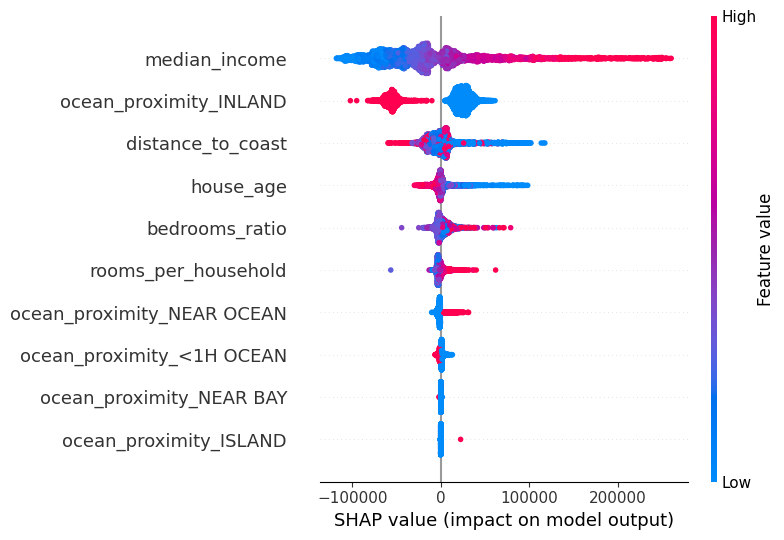

['preprocessor.pkl']

<Figure size 640x480 with 0 Axes>

In [40]:
# Load data
loader = DataLoader("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")
df = loader.load_data()

# Feature engineering
engineer = FeatureEngineer()
X = engineer.fit_transform(df)
y = df['median_house_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess data
preprocessor = build_preprocessor()
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
num_features = ['median_income', 'house_age', 'rooms_per_household', 'bedrooms_ratio', 'distance_to_coast']
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].feature_names_out_
all_features = num_features + list(cat_features)

# Train model
model = train_model(X_train_processed, y_train)

# Evaluate model
y_pred = model.predict(X_test_processed)
print("\n=== Model Performance ===")
print(f"MAE: ${mean_absolute_error(y_test, y_pred):,.0f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# Visualize results
visualize_results(model, X_test_processed, all_features)

# Save model
joblib.dump(model, 'final_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')